# Predict ages using linear regression

In [177]:
%matplotlib inline

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [179]:
df1 = pd.read_pickle('Mc_Gar_Sant')

In [180]:
df1.head()

,CP/CB_candidate_flag,DC,E_M,E_Teff,E_logg,FQ,Flag,FliPer_Class,GAIA_inary_flag,GAIA_subgiant_flag,...,teff_percentile_lower,teff_percentile_upper,teff_prov,teff_val,tm_designation,visibility_periods_used,w,v_b,v_tan,loglum_val
0,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3605.000000,4485.666504,KIC0,3765.000000,2MASS J19241533+3638089,15.0,0.4503,-23.237122,43.610090,-0.349625
1,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,4398.880371,4705.450195,PHO1,4424.760254,2MASS J19241682+3646501,15.0,0.7229,2.149538,11.256302,NaN
2,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3928.000000,4284.449707,KIC0,4109.000000,2MASS J19243578+3643257,16.0,0.6061,15.602643,17.702679,-0.973228
3,NaN,1.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3730.750000,4269.720215,PHO2,3823.333252,2MASS J19252036+3648231,15.0,0.5445,-11.929150,20.490185,-0.847908
4,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3956.135010,4525.220215,PHO1,4239.220215,2MASS J19263622+3650126,15.0,0.3939,13.596025,17.989548,-0.995518


Calculate ages.

In [982]:
from stardate.lhf import age_model
ages = []
for i in range(len(df1)):
    bprp = df1.phot_bp_mean_mag.values[i] - df1.phot_rp_mean_mag.values[i]
    log10_period = np.log10(df1.Prot.values[i])
    log10_age_yrs = age_model(log10_period, bprp)
    age_gyr = (10**log10_age_yrs)*1e-9
    ages.append(age_gyr)

ages = np.array(ages)

# Add realistic noise (20% uncertainties).
ages += np.random.randn(len(ages))*(.2*ages)
df1["age"] = ages

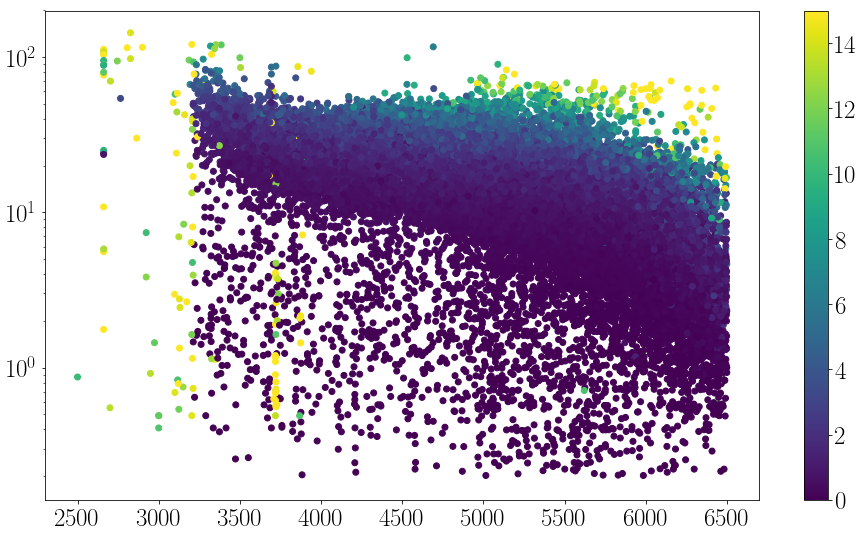

In [983]:
plt.figure(figsize=(16, 9))

plt.scatter(df1.Teff.values, df1.Prot.values, c=df1.age, vmin=0, vmax=15)
plt.colorbar()
plt.yscale("log")

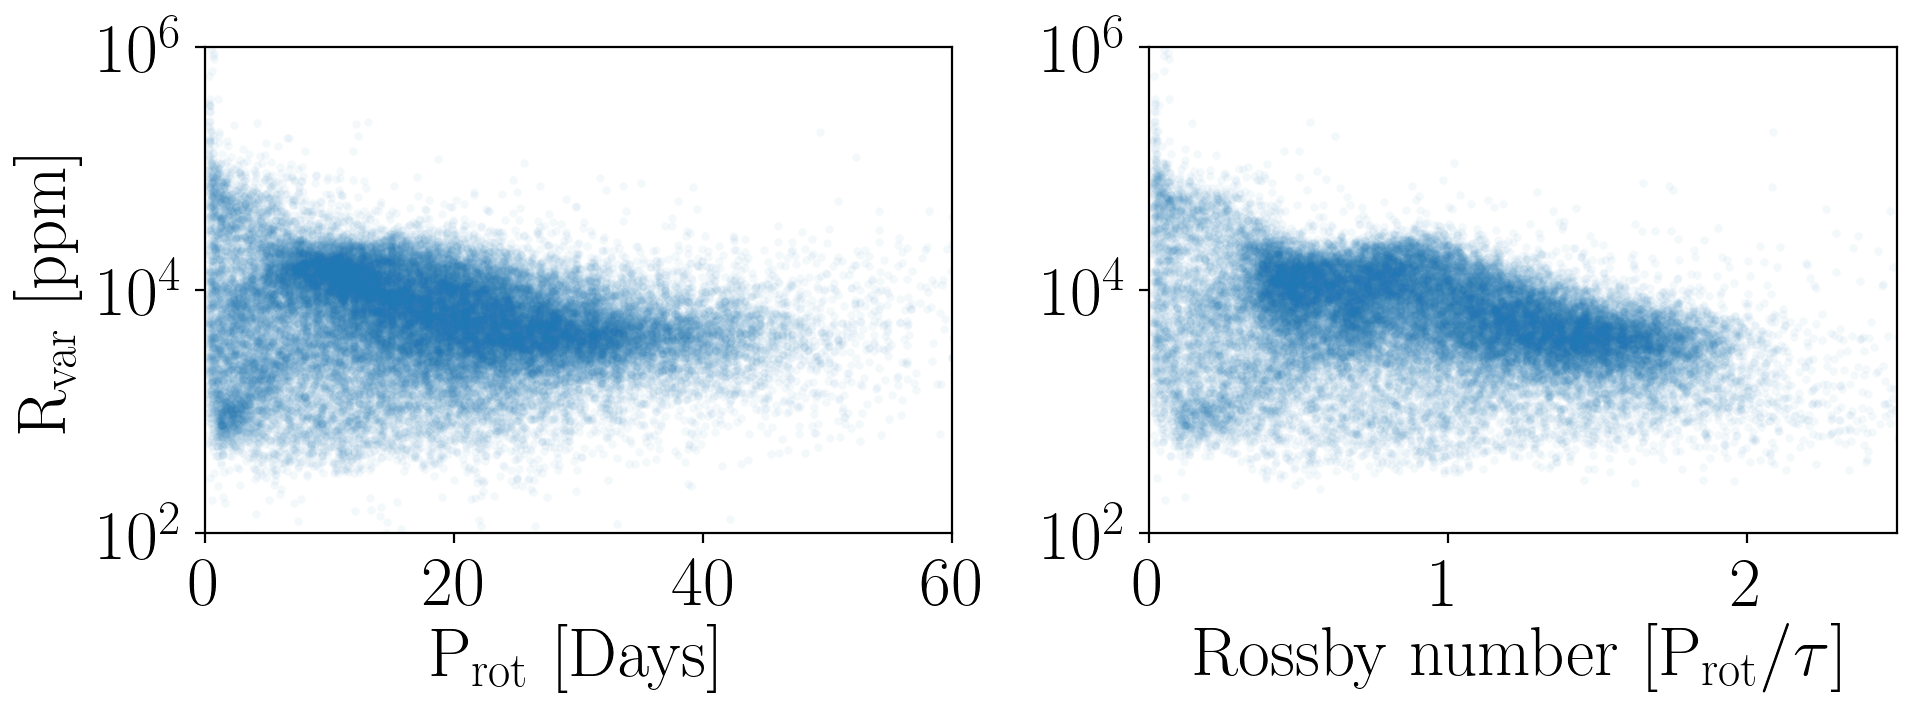

In [984]:
plt.figure(figsize=(10, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.plot(df1["Prot"], df1["Rper"], ".", alpha=.05, mec="none")
plt.yscale("log")
plt.ylabel("$\mathrm{R_{var}~[ppm]}$")
plt.xlabel("$\mathrm{P_{rot}~[Days]}$")
plt.xlim(0, 60)
plt.ylim(1e2, 1e6)

from stardate.lhf import convective_overturn_time

tau = convective_overturn_time(df1["Mass"])
Ro = df1["Prot"]/tau

plt.subplot(1, 2, 2)
plt.plot(Ro, df1["Rper"], ".", alpha=.05, mec="none")
plt.yscale("log")
plt.xlabel("$\mathrm{Rossby~number~[P_{rot}}/\\tau]$")
plt.xlim(0, 2.5)
plt.ylim(1e2, 1e6)
plt.tight_layout()

df1["Ro"] = Ro
plt.savefig("Rvar.pdf")
plt.savefig("Rvar")

Mask missing values

In [985]:
features = [df1["Rper"], df1["teff"], df1["bp_g"], df1["loglum_val"], df1["phot_g_mean_flux_over_error"],
            df1["radius_val"], df1["v_tan"], df1["v_b"], df1["b"], df1["age"]]

m = np.isfinite(df1["Rper"].values) * (df1["Rper"].values !=0)
for f in features[1:]:
    m &= np.isfinite(f.values) * (f.values != 0)
    
df = df1.iloc[m]
print(np.shape(df), np.shape(df1))

# Also, do a temperature and prot cut
m = (df.teff.values < 6000) * (df.teff.values > 3500)
m &= (df.Prot.values > 10)

# Do a rossby number cut.
m &= df.Ro.values > 1

df = df.iloc[m]
print(np.shape(df))

(34997, 172) (38573, 172)
(12139, 172)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


(200.0, 100000.0)

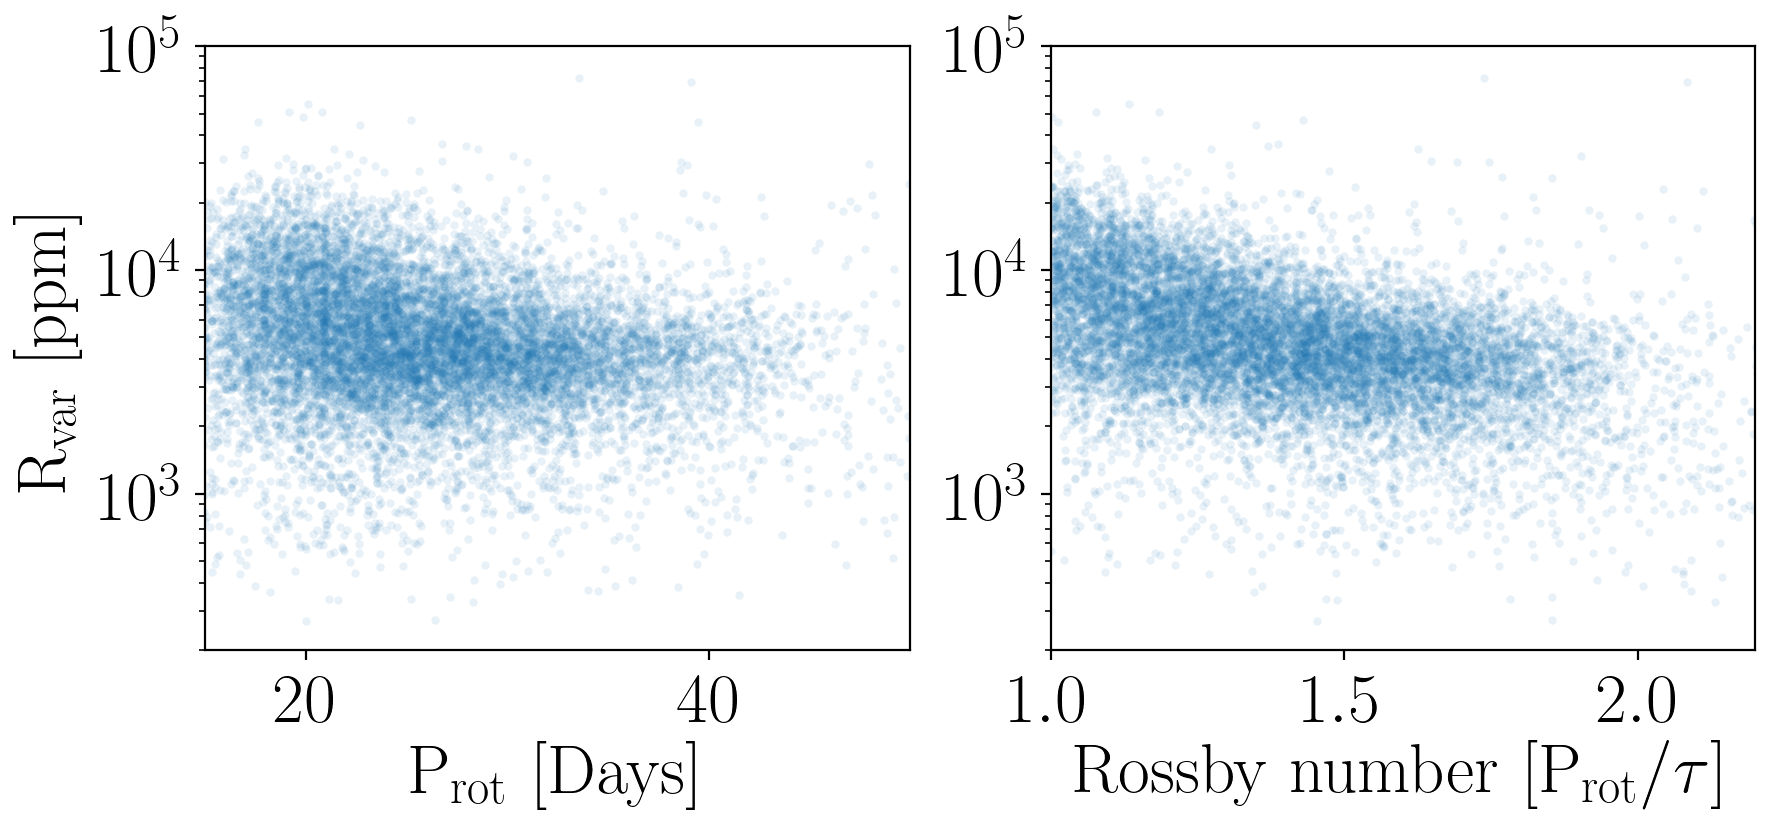

In [986]:
plt.figure(figsize=(10, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.plot(df["Prot"], df["Rper"], ".", alpha=.1, mec="none")
plt.yscale("log")
plt.ylabel("$\mathrm{R_{var}~[ppm]}$")
plt.xlabel("$\mathrm{P_{rot}~[Days]}$")
plt.xlim(15, 50)
plt.ylim(2e2, 1e5)

plt.subplot(1, 2, 2)
plt.plot(df["Ro"], df["Rper"], ".", alpha=.1, mec="none")
plt.yscale("log")
plt.xlabel("$\mathrm{Rossby~number~[P_{rot}}/\\tau]$")
plt.xlim(1, 2.2)
plt.ylim(2e2, 1e5)

Linear least squares

In [987]:
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

Define the y-vector of values you want to predict:

In [988]:
y = df.age.values

Define the X matrix (the data you're using to predict y).

In [989]:
# from itertools import combinations_with_replacement

# args = df["Rper"], df["teff"], df["bp_g"], df["loglum_val"], df["phot_g_mean_flux_over_error"], \
#            df["radius_val"], df["v_tan"], df["v_b"], df["b"]
# X = list(args)
# for a, b in combinations_with_replacement(args, 2):
#     X.append(a * b)
# X = np.array(X).T
# print(np.shape(X), len(args))

(12139, 54) 9


Define features.

In [1019]:
def abs_mag(m, D):
    """
    m - M = 5log(D) - 5
    M = m - 5log(D) + 5
    """
    return m - 5*np.log10(D) + 5

abs_G = abs_mag(df.phot_g_mean_mag.values, 1./df.parallax.values)
df["abs_G"] = abs_G
df["bprp"] = df.phot_bp_mean_mag.values - df.phot_rp_mean_mag.values

X_simple = np.vstack((df["Rper"], df["bprp"],# df["Prot"],
                      df["abs_G"])).T
print(np.shape(X_simple), np.shape(y))

(12139, 3) (12139,)


Shuffle X and y and select training and testing sets.

In [1020]:
# Define the number of training and validating stars.
Ntrain = 6000

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]
X_train_simple = X_simple[train_inds, :]
X_test_simple = X_simple[test_inds, :]

In [1021]:
print(np.shape(X_train), np.shape(y), np.shape(X_train_simple))
print(np.shape(X_test))

(6000, 54) (12139,) (6000, 3)
(6139, 54)


Solve for the weight vector.

In [1022]:
weights = train(y_train, X_train)

Compute the predicted y-values.

In [1023]:
A = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
y_predict = np.dot(weights.T, A.T)

Plot the prediction for the training set.

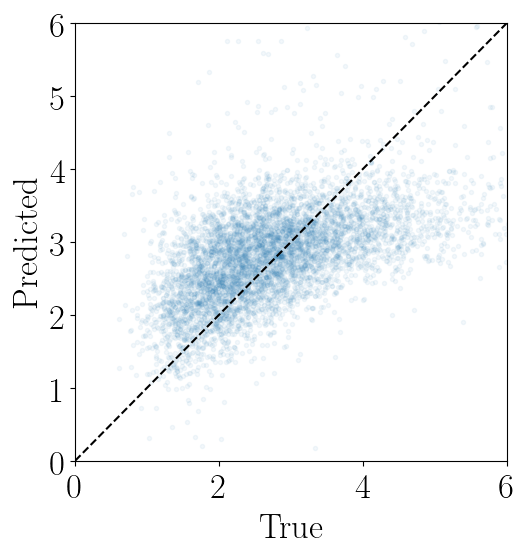

In [1024]:
xs = np.linspace(0, 15, 100)

plt.figure(figsize=(6, 6), dpi=100)
plt.plot(y_train, y_predict.T, ".", alpha=.05)
plt.plot(xs, xs, "k--")
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.xlabel("$\mathrm{True}$")
plt.ylabel("$\mathrm{Predicted}$")
plt.subplots_adjust(left=.18, bottom=.15)

Now try random forest.

In [1025]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

Find optimum number of trees. Optimums: n_estimators = 7, criterion="mse" (default), max_depth = "none"

In [1026]:
# def rms(y):
#     return np.sqrt(np.mean(y**2))

# for i in range(0, 10):
#     rmss = []
#     for j in trange(10):
#         regr = RandomForestRegressor()
#         regr.fit(X_train_simple, y_train)
#         x1, x2 = y_test, regr.predict(X_test_simple)
#         rmss.append(rms(x1 - x2))
#     print(i, np.median(np.array(rmss)))
    
# # print(regr.feature_importances_)
    
# # regr = RandomForestRegressor(n_estimators=7, criterion="mae")
# # regr.fit(X_train_simple, y_train)
# # x1, x2 = y_test, regr.predict(X_test_simple)
# # print(rms(x1 - x2))

# # regr = RandomForestRegressor(n_estimators=7, criterion="mse")
# # regr.fit(X_train_simple, y_train)
# # x1, x2 = y_test, regr.predict(X_test_simple)
# # print(rms(x1 - x2))

In [1027]:
np.random.seed(42)
regr = RandomForestRegressor(n_estimators=7)

regr.fit(X_train_simple, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1028]:
f = np.array(["Rper", "bprp", "abs_G"])#, "v_tan", "v_b", "b"])
importance = regr.feature_importances_
inds = np.argsort(importance)

print(importance[inds])
print(f[inds])

[0.31076076 0.33822756 0.35101168]
['bprp' 'abs_G' 'Rper']


In [1038]:
def rms(y):
    return np.sqrt(np.mean(y**2))

x1, x2 = y_test, regr.predict(X_test_simple)
print("RMS = ", rms(x1 - x2), "Gyr")
err = y_test - regr.predict(X_test_simple)
rerr = abs(err)/y_test
percentage_err = rerr*100
print("median relative error = ", np.median(abs(err)/y_test)*100, "%")

RMS =  1.2537616859340983 Gyr
median relative error =  22.903652080643848 %


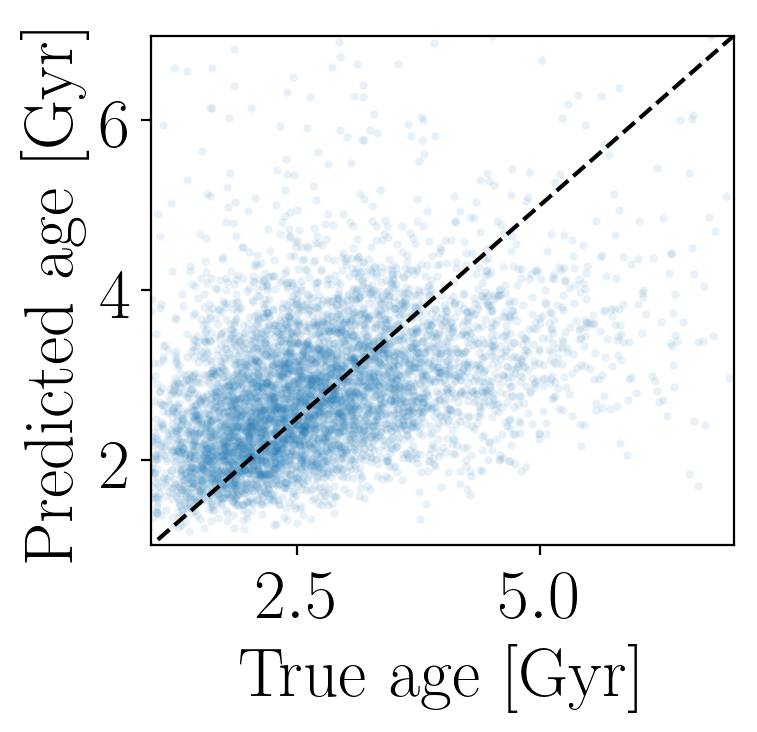

In [1030]:
plotpar = {'axes.labelsize': 25,
           'font.size': 20,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plt.figure(figsize=(7, 4), dpi=200)
# plt.subplot(1, 2, 1)
# xs = np.linspace(y_train.min(), y_train.max(), 100)
# plt.plot(y_train, regr.predict(X_train_simple), ".", mec="none", alpha=.1)
# plt.plot(xs, xs, "k--")
# plt.xlim(1, 7)
# plt.ylim(1, 7)
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Predicted~age~[Gyr]}$")
plt.tight_layout()
# plt.title("$\mathrm{Train}$")

plt.subplot(1, 2, 2)
xs = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(y_test, regr.predict(X_test_simple), ".", mec="none", alpha=.1)
plt.plot(xs, xs, "k--")
plt.xlim(1, 7)
plt.ylim(1, 7)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.tight_layout()
# plt.title("$\mathrm{Test}$")
plt.ylabel("$\mathrm{Predicted~age~[Gyr]}$")


# plt.savefig("random_forest_ages")
# plt.savefig("random_forest_ages.pdf")
# plt.savefig("random_forest_ages_p")
# plt.savefig("random_forest_ages_p.pdf")
plt.savefig("random_forest_ages_nop")
plt.savefig("random_forest_ages_nop.pdf")

0.5025773182188313
1.2537616859340983


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


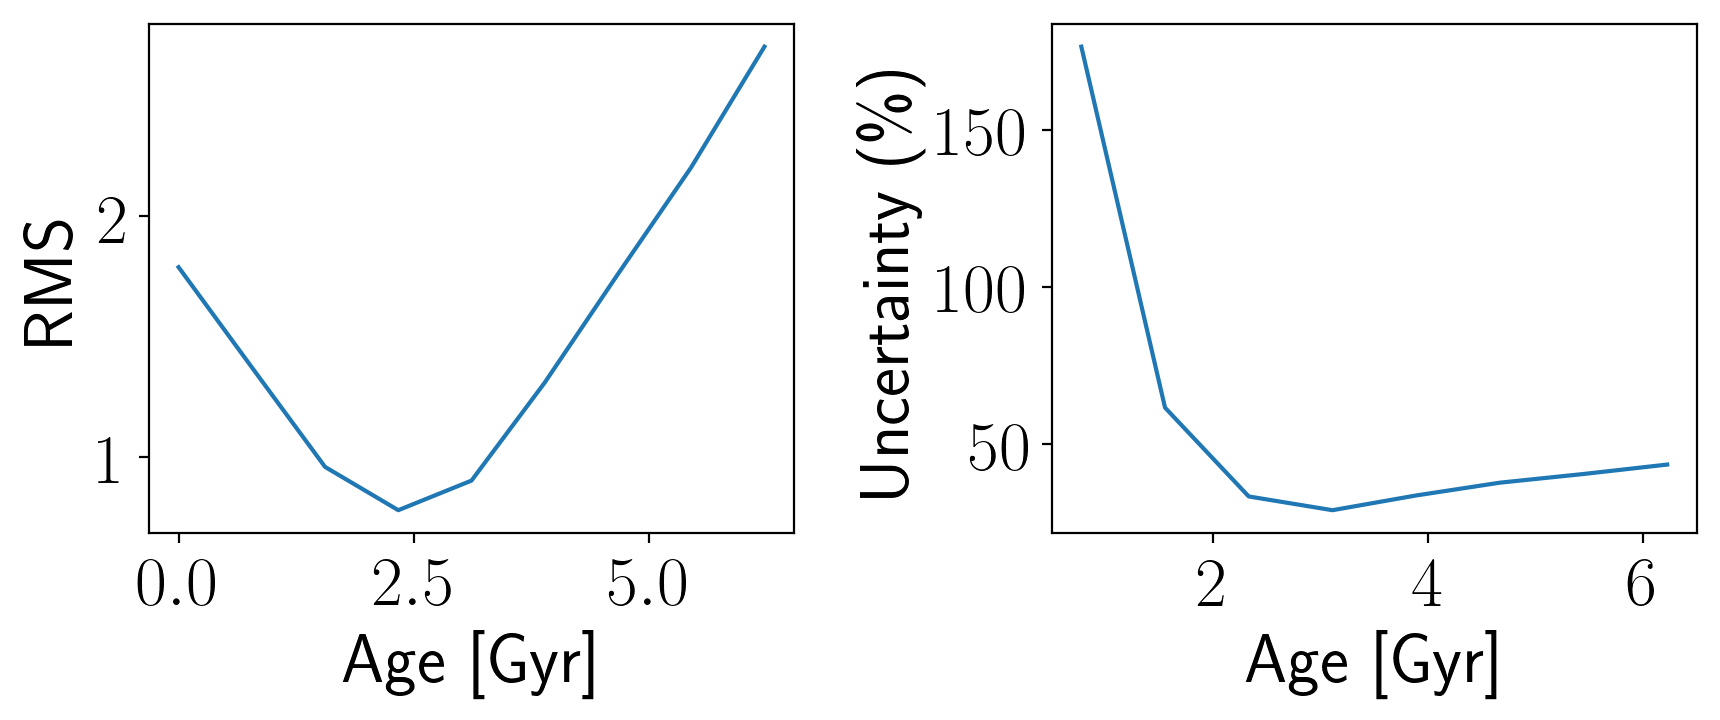

In [1031]:
def rms(y):
    return np.sqrt(np.mean(y**2))

x1, x2 = y_train, regr.predict(X_train_simple)
print(rms(x1 - x2))

x1, x2 = y_test, regr.predict(X_test_simple)
print(rms(x1 - x2))

rmss = []
age_bins = np.linspace(0, 7, 10)
for i in range(len(age_bins)-1):
    m = (age_bins[i] < x1) * (x1 < age_bins[i+1])
    rmss.append(rms(x1[m] - x2[m]))

plt.figure(figsize=(9, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.plot(age_bins[:-1], rmss)
plt.xlabel("Age [Gyr]")
plt.ylabel("RMS")

plt.subplot(1, 2, 2)
a = age_bins[:-1]
relerr = rmss/age_bins[:-1]
skip = 5
plt.plot(a, relerr*100)
plt.xlabel("Age [Gyr]")
plt.ylabel("Uncertainty (\%)")
plt.tight_layout()

In [1032]:
err = y_test - regr.predict(X_test_simple)
rerr = abs(err)/y_test
percentage_err = rerr*100
print(np.median(abs(err)/y_test)*100)
print(min(percentage_err), max(percentage_err))

22.903652080643848
0.022396981319436522 702.8988113058024


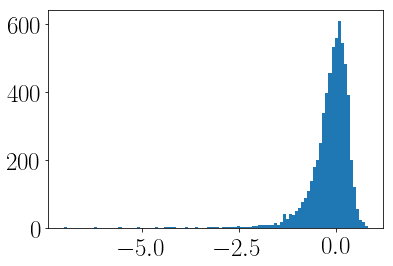

In [1033]:
plt.hist(err/y_test, 100);

(0, 7)

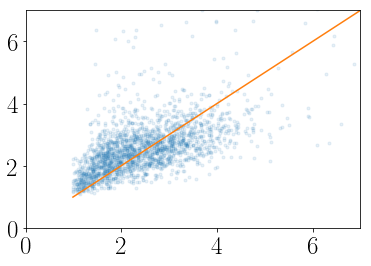

In [597]:
plt.plot(y_test, regr.predict(X_test_simple), ".", alpha=.1)
plt.plot(xs, xs)
plt.xlim(0, 7)
plt.ylim(0, 7)

In [436]:
%timeit regr.predict(X_train_simple)

38.4 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [438]:
(38.4*1e-3*2e-4)

7.68e-06

7 micro-seconds per star.

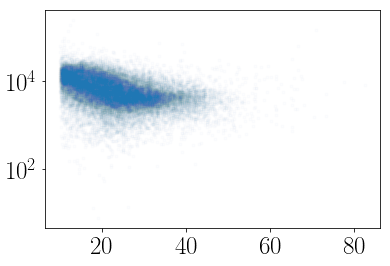

(0, 2.5)

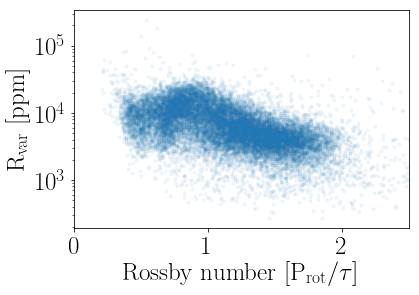

(0, 2.5)

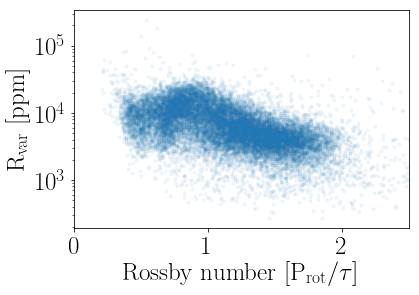

In [ ]:
# from tqdm import trange

# def leave_one_out(X, y):
#     predict = np.empty_like(y)
    
#     for i in trange(len(y)):
        
#         # Mask out one point
#         m = np.ones_like(y, dtype="bool")
#         m[i] = False
        
#         # Train on the rest
#         regr.fit(X[m], y[m])
        
#         # Predict for that point
#         predict[i] = regr.predict([X[i, :]])
        
#     return predict

# predict = leave_one_out(X_train_simple[:1000, :], y_train[:1000])

# plt.plot(y_train[:1000], predict[:1000], ".")
# xs = np.linspace(0, 6, 100)
# plt.plot(xs, xs, "k--")
# plt.xlim(0, 6)
# plt.ylim(0, 6)

In [951]:
x = np.random.randn(1000)

In [952]:
%timeit np.percentile(x, 5) - np.percentile(x, 95)

132 µs ± 920 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [957]:
132 * 1e-6 * 1e9 / 60 / 60

36.66666666666666

In [956]:
2*1e-6 * 1e9 / 60

33.333333333333336